In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.compose
import sklearn.metrics
import lightgbm as lgb

from sklearn.model_selection         import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics                 import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics                 import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics                 import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing           import OneHotEncoder
from sklearn.preprocessing           import LabelEncoder

from imblearn.over_sampling          import SMOTE, ADASYN
from imblearn.under_sampling         import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
from imblearn.combine                import SMOTEENN, SMOTETomek
from imblearn.metrics                import geometric_mean_score, make_index_balanced_accuracy


from lightgbm                        import LGBMClassifier
from sklearn.ensemble                import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model            import LogisticRegression
from sklearn.neural_network          import MLPClassifier
from sklearn.preprocessing           import StandardScaler
from xgboost                         import XGBClassifier
from scipy.stats                     import uniform, randint
from datetime                        import datetime





/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Data Collection**
In this section, I will gather all data I require.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/sample_data/heart.csv')

display(df.head())
print("="*140)
print("Original shape:", df.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Original shape: (303, 14)


# **Data Exploration**
In this section, i will explore my data

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
df.nunique()

,0
age,41
sex,2
cp,4
trestbps,49
chol,152
fbs,2
restecg,3
thalach,91
exang,2
oldpeak,40


<Axes: xlabel='target'>

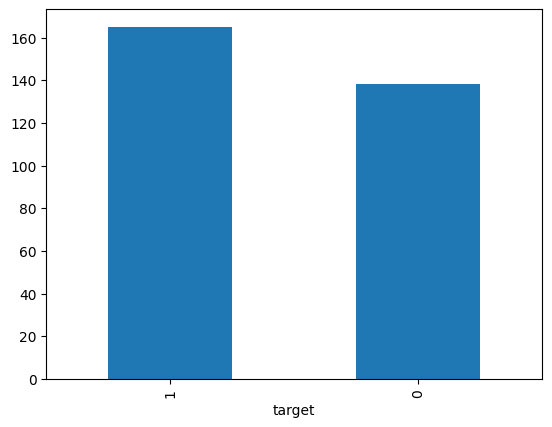

In [ ]:
df['target'].value_counts().plot(kind="bar")

# **Data Preprocessing/ Model Comparison**
In this section, i will compare  models.
I will be processing my dataset in this section first by finding the best algorithm and hyperparameters by doing the below:

* Training with different algorithms (Neural Network, Gradient Boosting, AdaBoost)
* Training with and without SMOTE
* Use RandomizedSearchCV to find best hyperparameters
* Compare all results to find the best combination

In [ ]:
def print_metrics(y_true, y_pred):
    gmean = geometric_mean_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prod = gmean * acc * f1
    return gmean, acc, f1, prod

def prepare_data(features, targets):
    X_train, X_test, y_train, y_test = train_test_split(
        features, targets,
        test_size=0.2,
        shuffle=True,
        stratify=targets,
        random_state=100
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=0.25,
        shuffle=True,
        stratify=y_train,
        random_state=100
    )

    smote = SMOTE(random_state=100)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    return X_train, X_valid, X_test, y_train, y_valid, y_test, X_res, y_res

def format_results(model_name, data_type, metrics):
    gmean, acc, f1, prod = metrics
    return (f"\n{model_name} - {data_type} Data Performance:\n"
            f"G-Mean = {gmean:.3f}, Accuracy = {acc:.3f}, "
            f"F1 = {f1:.3f}, Product = {prod:.3f}")

def run_adaboost(X_train, y_train, X_res, y_res, X_valid, y_valid):
    print("\n" + "="*50)
    print("Starting AdaBoost Training")
    print("="*50)
    results = []

    print("\nFitting AdaBoost on original data...")
    ada_original = AdaBoostClassifier(
        n_estimators=132,
        learning_rate=0.07117896638863862,
        algorithm='SAMME',
        random_state=100
    )
    ada_original.fit(X_train, y_train)
    print("Evaluating AdaBoost on original data...")
    val_pred_original = ada_original.predict(X_valid)
    metrics_original = print_metrics(y_valid, val_pred_original)
    results.append(format_results("AdaBoost", "Original", metrics_original))

    print("\nFitting AdaBoost on SMOTE data...")
    ada_smote = AdaBoostClassifier(
        n_estimators=132,
        learning_rate=0.07117896638863862,
        algorithm='SAMME',
        random_state=100
    )
    ada_smote.fit(X_res, y_res)
    print("Evaluating AdaBoost on SMOTE data...")
    val_pred_smote = ada_smote.predict(X_valid)
    metrics_smote = print_metrics(y_valid, val_pred_smote)
    results.append(format_results("AdaBoost", "SMOTE", metrics_smote))

    print('\n'.join(results))
    print("\nAdaBoost training completed!")
    return ada_original, ada_smote

def run_gradient_boosting(X_train, y_train, X_res, y_res, X_valid, y_valid):
    print("\n" + "="*50)
    print("Starting Gradient Boosting Training")
    print("="*50)
    results = []

    param_dist = {
        'n_estimators': randint(1000, 2000),
        'learning_rate': uniform(0.05, 0.15),
        'max_depth': randint(10, 20),
        'min_samples_split': randint(4, 8),
        'min_samples_leaf': randint(3, 6),
        'subsample': uniform(0.8, 0.2)
    }

    print("\nPerforming hyperparameter tuning on original data...")
    gb_original = RandomizedSearchCV(
        estimator=GradientBoostingClassifier(random_state=100),
        param_distributions=param_dist,
        n_iter=75,
        scoring='f1',
        cv=5,
        random_state=100,
        n_jobs=-1,
        verbose=2
    )
    gb_original.fit(X_train, y_train)
    print("\nEvaluating best model on original data...")
    val_pred_original = gb_original.predict(X_valid)
    metrics_original = print_metrics(y_valid, val_pred_original)
    results.append(format_results("Gradient Boosting", "Original", metrics_original))
    results.append(f"Best parameters (Original): {gb_original.best_params_}")

    print("\nPerforming hyperparameter tuning on SMOTE data...")
    gb_smote = RandomizedSearchCV(
        estimator=GradientBoostingClassifier(random_state=100),
        param_distributions=param_dist,
        n_iter=75,
        scoring='f1',
        cv=5,
        random_state=100,
        n_jobs=-1,
        verbose=2
    )
    gb_smote.fit(X_res, y_res)
    print("\nEvaluating best model on SMOTE data...")
    val_pred_smote = gb_smote.predict(X_valid)
    metrics_smote = print_metrics(y_valid, val_pred_smote)
    results.append(format_results("Gradient Boosting", "SMOTE", metrics_smote))
    results.append(f"Best parameters (SMOTE): {gb_smote.best_params_}")

    print('\n'.join(results))
    print("\nGradient Boosting training completed!")
    return gb_original.best_estimator_, gb_smote.best_estimator_

def run_neural_network(X_train, y_train, X_res, y_res, X_valid, y_valid):
    print("\n" + "="*50)
    print("Starting Neural Network Training")
    print("="*50)
    results = []

    param_dist = {
        'hidden_layer_sizes': [(x,y,z) for x in [150, 200] for y in [75, 100] for z in [50, 75]],
        'activation': ['relu', 'tanh'],
        'alpha': uniform(0.0001, 0.01),
        'learning_rate_init': uniform(0.001, 0.01),
        'batch_size': randint(32, 128),
        'max_iter': [500]
    }

    print("\nPerforming hyperparameter tuning on original data...")
    nn_original = RandomizedSearchCV(
        estimator=MLPClassifier(random_state=100),
        param_distributions=param_dist,
        n_iter=75,
        scoring='f1',
        cv=5,
        random_state=100,
        n_jobs=-1,
        verbose=2
    )
    nn_original.fit(X_train, y_train)
    print("\nEvaluating best model on original data...")
    val_pred_original = nn_original.predict(X_valid)
    metrics_original = print_metrics(y_valid, val_pred_original)
    results.append(format_results("Neural Network", "Original", metrics_original))
    results.append(f"Best parameters (Original): {nn_original.best_params_}")

    print("\nPerforming hyperparameter tuning on SMOTE data...")
    nn_smote = RandomizedSearchCV(
        estimator=MLPClassifier(random_state=100),
        param_distributions=param_dist,
        n_iter=75,
        scoring='f1',
        cv=5,
        random_state=100,
        n_jobs=-1,
        verbose=2
    )
    nn_smote.fit(X_res, y_res)
    print("\nEvaluating best model on SMOTE data...")
    val_pred_smote = nn_smote.predict(X_valid)
    metrics_smote = print_metrics(y_valid, val_pred_smote)
    results.append(format_results("Neural Network", "SMOTE", metrics_smote))
    results.append(f"Best parameters (SMOTE): {nn_smote.best_params_}")

    print('\n'.join(results))
    print("\nNeural Network training completed!")
    return nn_original.best_estimator_, nn_smote.best_estimator_

def save_results_to_file(results_text):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"ml_results_{timestamp}.txt"

    with open(filename, 'w') as f:
        f.write(results_text)
    print(f"\nResults saved to {filename}")

if __name__ == "__main__":
    features = df.drop(columns=['target'])
    targets = df['target']

    all_results = []

    print("\nDataset Information:")
    print(f"Number of samples: {len(features)}")
    print(f"Number of features: {features.shape[1]}")
    print(f"Class distribution:\n{pd.Series(targets).value_counts()}")

    all_results.extend([
        "\nDataset Information:",
        f"Number of samples: {len(features)}",
        f"Number of features: {features.shape[1]}",
        f"Class distribution:\n{pd.Series(targets).value_counts()}"
    ])

    print("\nPreparing and splitting data...")
    X_train, X_valid, X_test, y_train, y_valid, y_test, X_res, y_res = prepare_data(features, targets)

    print("\nData Split Information:")
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_valid)}")
    print(f"Test set size: {len(X_test)}")
    print(f"SMOTE-balanced training set size: {len(X_res)}")

    all_results.extend([
        "\nData Split Information:",
        f"Training set size: {len(X_train)}",
        f"Validation set size: {len(X_valid)}",
        f"Test set size: {len(X_test)}",
        f"SMOTE-balanced training set size: {len(X_res)}"
    ])

    print("\n" + "="*50)
    print("Starting Model Training Pipeline")
    print("="*50)

    print("\nTraining AdaBoost models...")
    ada_orig, ada_smote = run_adaboost(X_train, y_train, X_res, y_res, X_valid, y_valid)
    all_results.append("\nAdaBoost training completed.")

    print("\nTraining Gradient Boosting models...")
    gb_orig, gb_smote = run_gradient_boosting(X_train, y_train, X_res, y_res, X_valid, y_valid)
    all_results.append("\nGradient Boosting training completed.")

    print("\nTraining Neural Network models...")
    nn_orig, nn_smote = run_neural_network(X_train, y_train, X_res, y_res, X_valid, y_valid)
    all_results.append("\nNeural Network training completed.")

    save_results_to_file('\n'.join(all_results))


Dataset Information:
Number of samples: 303
Number of features: 13
Class distribution:
target
1    165
0    138
Name: count, dtype: int64

Preparing and splitting data...

Data Split Information:
Training set size: 181
Validation set size: 61
Test set size: 61
SMOTE-balanced training set size: 198

Starting Model Training Pipeline

Training AdaBoost models...

Starting AdaBoost Training

Fitting AdaBoost on original data...
Evaluating AdaBoost on original data...

Fitting AdaBoost on SMOTE data...
Evaluating AdaBoost on SMOTE data...

AdaBoost - Original Data Performance:
G-Mean = 0.886, Accuracy = 0.885, F1 = 0.892, Product = 0.700

AdaBoost - SMOTE Data Performance:
G-Mean = 0.903, Accuracy = 0.902, F1 = 0.906, Product = 0.738

AdaBoost training completed!

Training Gradient Boosting models...

Starting Gradient Boosting Training

Performing hyperparameter tuning on original data...
Fitting 5 folds for each of 75 candidates, totalling 375 fits

Evaluating best model on original data

# **Model Training**

Second Phase (What i did below):

* Taking the lessons learned from the model comparison
* Implementing the best-performing combination (AdaBoost with SMOTE)
* Using the best model with the best optimal hyperparameters obtaining earlier.
* Evaluate the test set

In [ ]:
best_model = AdaBoostClassifier(
    n_estimators=132,
    learning_rate=0.07117896638863862,
    algorithm='SAMME',
    random_state=100
)

best_model.fit(X_res, y_res)

print("\nTest Set Performance (Final Evaluation):")
test_pred = best_model.predict(X_test)
gmean, acc, f1, prod = print_metrics(y_test, test_pred)
print(f"G-Mean = {gmean:.3f}, Accuracy = {acc:.3f}, F1 = {f1:.3f}, Product = {prod:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_pred))

joblib.dump(best_model, 'heart_model.sav')
print("\nModel saved as 'heart_model.sav'")


Test Set Performance (Final Evaluation):
G-Mean = 0.916, Accuracy = 0.918, F1 = 0.925, Product = 0.778

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.91      0.94      0.93        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61


Confusion Matrix:
[[25  3]
 [ 2 31]]

Model saved as 'heart_model.sav'


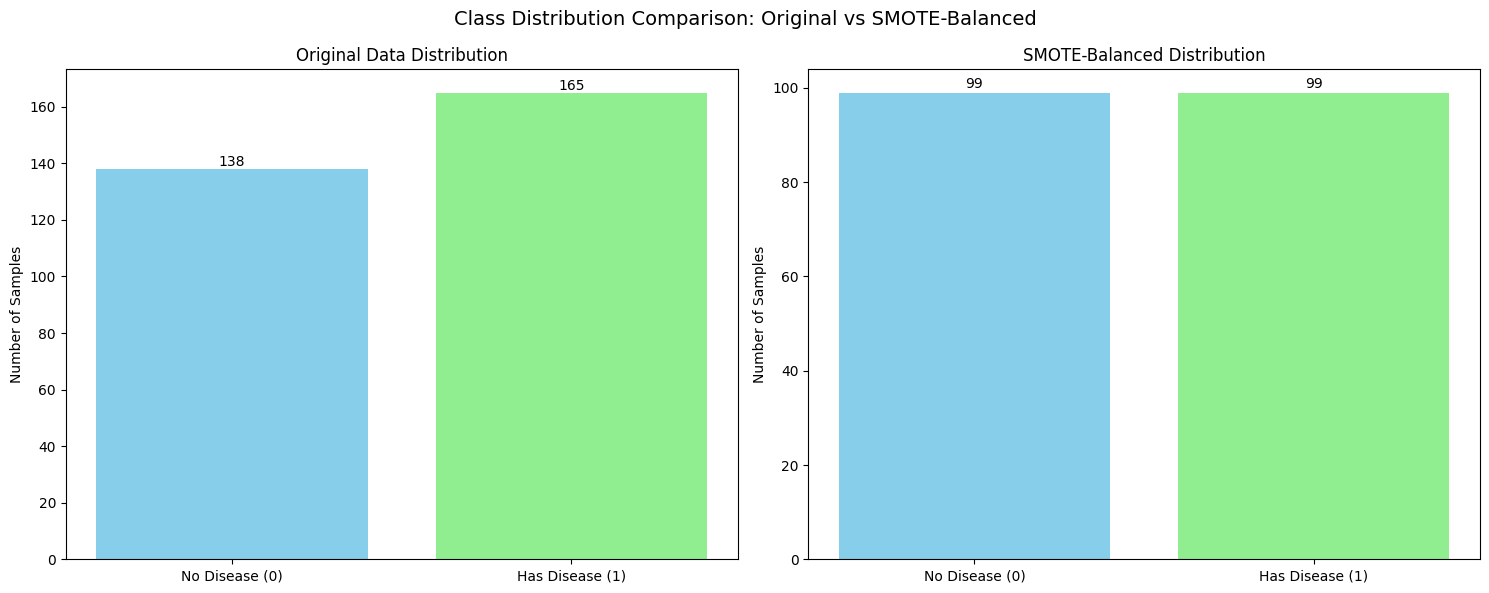


Class Distribution Numbers:

Original Data:
No Disease (0): 138
Has Disease (1): 165
Total: 303

After SMOTE Balancing:
No Disease (0): 99
Has Disease (1): 99
Total: 198


In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

original_dist = pd.Series(targets).value_counts()
ax1.bar(['No Disease (0)', 'Has Disease (1)'],
        [original_dist[0], original_dist[1]],
        color=['skyblue', 'lightgreen'])
ax1.set_title('Original Data Distribution')
ax1.set_ylabel('Number of Samples')

for i, v in enumerate([original_dist[0], original_dist[1]]):
    ax1.text(i, v + 1, str(v), ha='center')

smote_dist = pd.Series(y_res).value_counts()
ax2.bar(['No Disease (0)', 'Has Disease (1)'],
        [smote_dist[0], smote_dist[1]],
        color=['skyblue', 'lightgreen'])
ax2.set_title('SMOTE-Balanced Distribution')
ax2.set_ylabel('Number of Samples')

for i, v in enumerate([smote_dist[0], smote_dist[1]]):
    ax2.text(i, v + 1, str(v), ha='center')

plt.suptitle('Class Distribution Comparison: Original vs SMOTE-Balanced', fontsize=14)
plt.tight_layout()
plt.show()

print("\nClass Distribution Numbers:")
print("\nOriginal Data:")
print(f"No Disease (0): {original_dist[0]}")
print(f"Has Disease (1): {original_dist[1]}")
print(f"Total: {original_dist.sum()}")

print("\nAfter SMOTE Balancing:")
print(f"No Disease (0): {smote_dist[0]}")
print(f"Has Disease (1): {smote_dist[1]}")
print(f"Total: {smote_dist.sum()}")

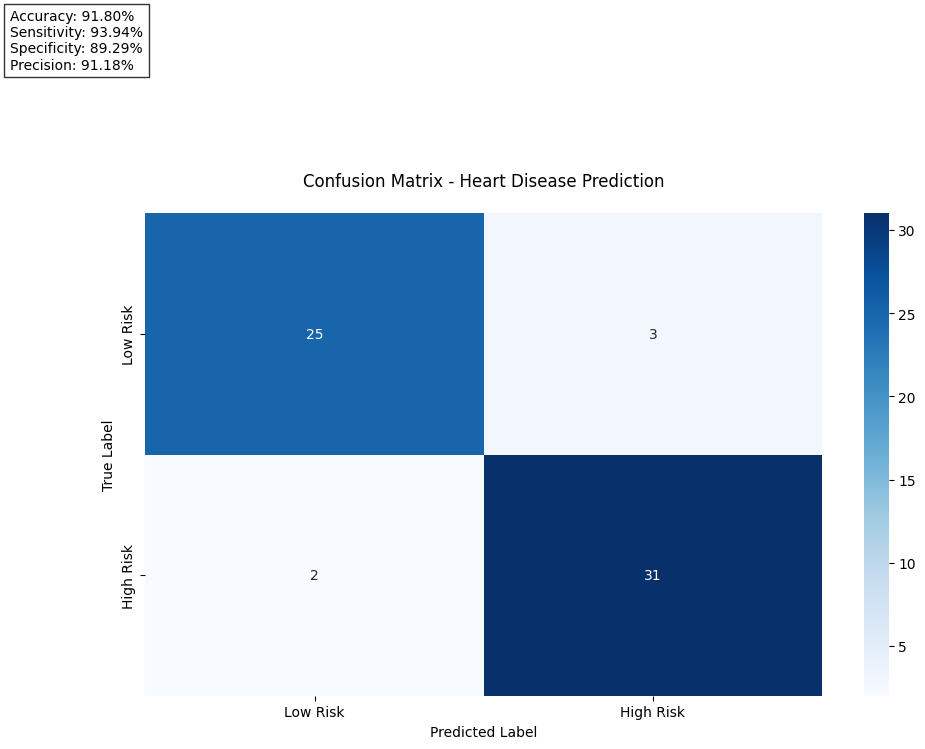

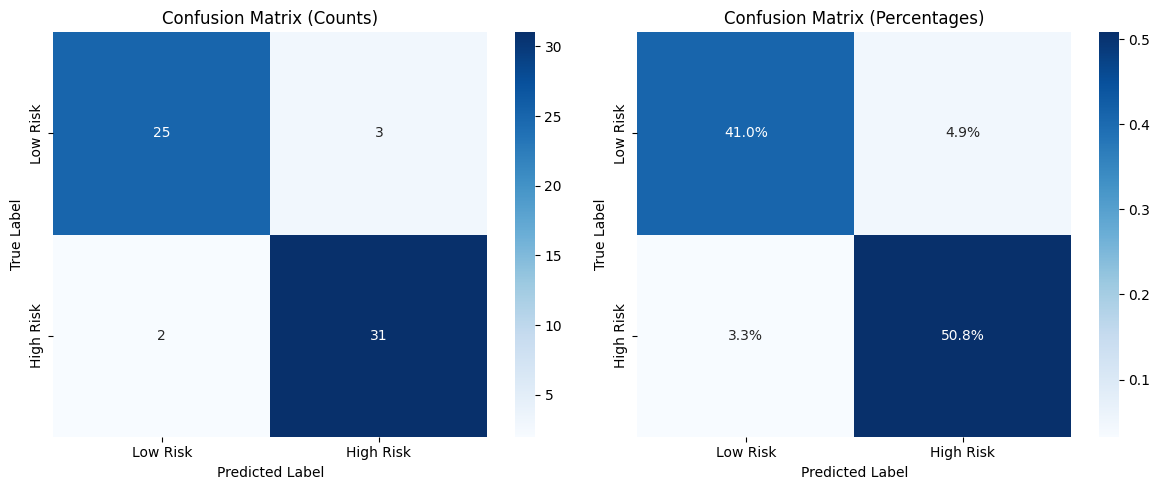

In [ ]:
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])

plt.title('Confusion Matrix - Heart Disease Prediction', pad=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.text(-0.4, -0.6,
         f'Accuracy: {(cm[0,0] + cm[1,1])/np.sum(cm):.2%}\n' +
         f'Sensitivity: {cm[1,1]/(cm[1,0] + cm[1,1]):.2%}\n' +
         f'Specificity: {cm[0,0]/(cm[0,0] + cm[0,1]):.2%}\n' +
         f'Precision: {cm[1,1]/(cm[0,1] + cm[1,1]):.2%}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

The confusion matrix visualization shows that:
- The model correctly identified 25 low-risk cases (true negatives)
- Successfully detected 31 high-risk cases (true positives)
- Had only 2 dangerous miss (false negative)
- Made 3 cautious errors (false positives)

This performance is particularly strong for medical applications as:
1. The low false negative rate (only 2) means the model will rarely miss high-risk cases
2. The number of false positives (3) is reasonably low.
3. The overall accuracy which is above 90% demonstrates robust performance and indicates it will perform well in detecting both low risk and high risk cases.

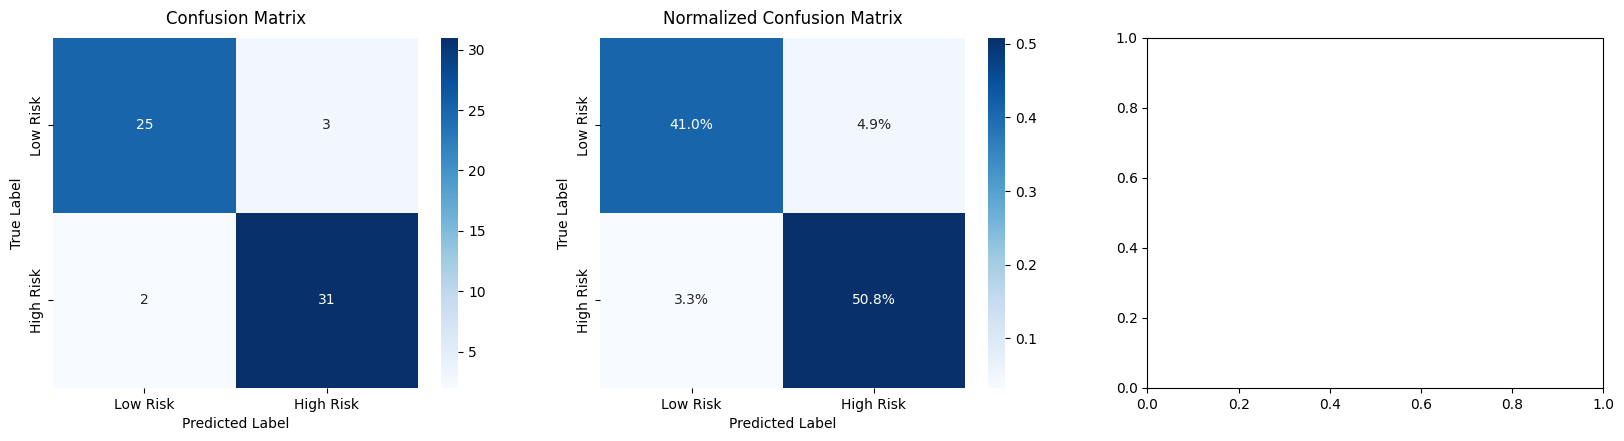

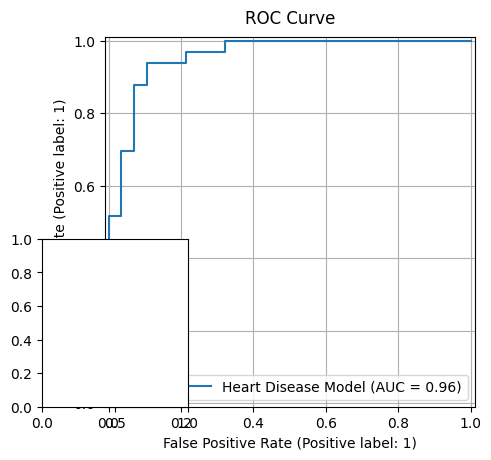

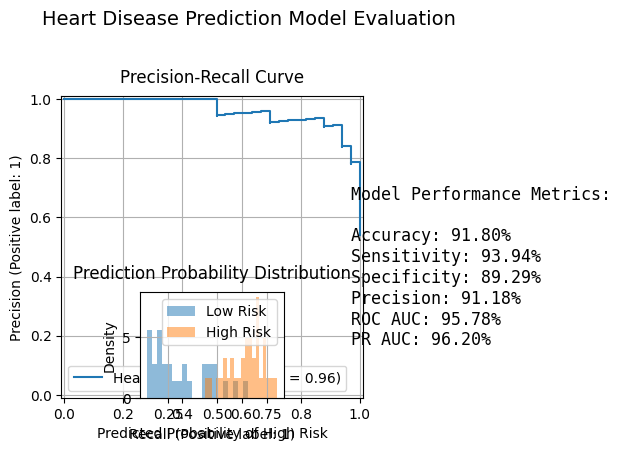

In [ ]:

y_pred = ada_smote.predict(X_test)
y_pred_proba = ada_smote.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix', pad=10, size=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Normalized Confusion Matrix', pad=10, size=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 3)
RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name="Heart Disease Model"
)
plt.title('ROC Curve', pad=10, size=12)
plt.grid(True)

plt.subplot(2, 3, 4)
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name="Heart Disease Model"
)
plt.title('Precision-Recall Curve', pad=10, size=12)
plt.grid(True)

plt.subplot(2, 3, 5)
for label in [0, 1]:
    mask = y_test == label
    plt.hist(y_pred_proba[mask],
             alpha=0.5,
             label=f'Class {label}',
             bins=20,
             density=True)
plt.xlabel('Predicted Probability of High Risk')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution', pad=10, size=12)
plt.legend(['Low Risk', 'High Risk'])
plt.grid(True)

plt.subplot(2, 3, 6)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

pr_auc = average_precision_score(y_test, y_pred_proba)

metrics = {
    'Accuracy': (cm[0,0] + cm[1,1])/np.sum(cm),
    'Sensitivity': cm[1,1]/(cm[1,0] + cm[1,1]),
    'Specificity': cm[0,0]/(cm[0,0] + cm[0,1]),
    'Precision': cm[1,1]/(cm[0,1] + cm[1,1]),
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
}

plt.axis('off')
metrics_text = '\n'.join([f'{k}: {v:.2%}' for k, v in metrics.items()])
plt.text(0.1, 0.5, f'Model Performance Metrics:\n\n{metrics_text}',
         fontsize=12, family='monospace')

plt.suptitle('Heart Disease Prediction Model Evaluation', y=1.02, size=14)
plt.tight_layout()
plt.show()

This comprehensive visualization includes:

Standard Confusion Matrix

Shows raw counts of predictions


Normalized Confusion Matrix

Shows percentages for easier interpretation


ROC Curve

Shows trade-off between sensitivity and specificity
Includes AUC score


Precision-Recall Curve

Important for imbalanced datasets
Shows trade-off between precision and recall


Prediction Probability Distribution

Shows how confidently the model makes predictions
Helps identify potential threshold adjustments


Model Metrics Summary

All key metrics in one place
Easy to reference values





# **Model Validation**

In [ ]:
final_model = ada_smote

def predict_heart_disease(features_dict):
    features_df = pd.DataFrame([features_dict])

    pred = final_model.predict(features_df)[0]
    probs = final_model.predict_proba(features_df)[0]

    print("\nFeature values:")
    for feat, val in features_dict.items():
        print(f"{feat:10}: {val}")

    return pred, probs

test_cases = {
    'low_risk': {
        'age': 35,
        'sex': 0,        # female
        'cp': 0,         # typical angina
        'trestbps': 120, # normal blood pressure
        'chol': 200,     # normal cholesterol
        'fbs': 0,        # normal fasting blood sugar
        'restecg': 0,    # normal
        'thalach': 150,  # normal max heart rate
        'exang': 0,      # no exercise induced angina
        'oldpeak': 0,    # no ST depression
        'slope': 0,      # upsloping
        'ca': 0,         # no major vessels
        'thal': 0        # normal
    },
    'high_risk': {
        'age': 65,
        'sex': 1,        # male
        'cp': 2,         # atypical angina
        'trestbps': 160, # high blood pressure
        'chol': 280,     # high cholesterol
        'fbs': 1,        # high fasting blood sugar
        'restecg': 1,    # abnormal
        'thalach': 120,  # low max heart rate
        'exang': 1,      # has exercise induced angina
        'oldpeak': 2,    # significant ST depression
        'slope': 2,      # flat
        'ca': 3,         # multiple vessels
        'thal': 2        # reversible defect
    }
}

print("\nTesting predictions:")
for case_name, features in test_cases.items():
    print(f"\n{case_name.upper()} CASE:")
    pred, probs = predict_heart_disease(features)
    print(f"Prediction: {'Low Risk' if pred == 1 else 'High Risk'}")  # Changed interpretation
    print(f"Probability Scores - High Risk: {probs[0]:.2f}, Low Risk: {probs[1]:.2f}")  # Swapped labels

test_pred = final_model.predict(X_test)
print("\nModel Performance on Test Set:")
print(classification_report(y_test, test_pred))


Testing predictions:

LOW_RISK CASE:

Feature values:
age       : 35
sex       : 0
cp        : 0
trestbps  : 120
chol      : 200
fbs       : 0
restecg   : 0
thalach   : 150
exang     : 0
oldpeak   : 0
slope     : 0
ca        : 0
thal      : 0
Prediction: Low Risk
Probability Scores - High Risk: 0.41, Low Risk: 0.59

HIGH_RISK CASE:

Feature values:
age       : 65
sex       : 1
cp        : 2
trestbps  : 160
chol      : 280
fbs       : 1
restecg   : 1
thalach   : 120
exang     : 1
oldpeak   : 2
slope     : 2
ca        : 3
thal      : 2
Prediction: High Risk
Probability Scores - High Risk: 0.58, Low Risk: 0.42

Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.91      0.94      0.93        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



# Ground Truth

In [ ]:
statlog_check = pd.read_csv('/content/sample_data/Heart_disease_statlog.csv')

display(statlog_check.head())
print("="*140)
print("statlog shape:", statlog_check.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,3,130,322,0,2,109,0,2.4,1,3,1,1
1,67,0,2,115,564,0,2,160,0,1.6,1,0,3,0
2,57,1,1,124,261,0,0,141,0,0.3,0,0,3,1
3,64,1,3,128,263,0,0,105,1,0.2,1,1,3,0
4,74,0,1,120,269,0,2,121,1,0.2,0,1,1,0


statlog shape: (270, 14)


In [ ]:
cleveland_Current_Study_check = pd.read_csv('/content/sample_data/heart.csv')

display(cleveland_Current_Study_check.head())
print("="*140)
print("cleveland_Current_Study_check shape:", cleveland_Current_Study_check.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


cleveland_Current_Study_check shape: (303, 14)


In [ ]:
cleveland_Current_Study = pd.read_csv('/content/sample_data/Heart_disease_statlog.csv')
statlog = pd.read_csv('/content/sample_data/heart.csv')

cleveland_Current_Study_columns = cleveland_Current_Study.columns
statlog_columns = statlog.columns

print("Feature Comparison:")
print("-" * 50)
print("Cleveland Current Study features:", list(cleveland_Current_Study_columns[:-1]))
print("\nStatlog features:", list(statlog_columns[:-1]))

print("\nData Comparison:")
print("-" * 50)
print("\nCleveland Current Study Dataset:")
print("Total samples:", len(cleveland_Current_Study))
print("Class distribution:\n", cleveland_Current_Study['target'].value_counts())
print("\nDataset Info:")
cleveland_Current_Study.info()

print("\nStatlog Dataset:")
print("Total samples:", len(statlog))
print("Class distribution:\n", statlog['target'].value_counts())
print("\nDataset Info:")
statlog.info()

print("\nBasic Statistics Comparison:")
print("-" * 50)
print("\nCleveland Current Study Dataset:")
print(cleveland_Current_Study.describe())
print("\nStatlog Dataset:")
print(statlog.describe())

Feature Comparison:
--------------------------------------------------
Cleveland Current Study features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Statlog features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Data Comparison:
--------------------------------------------------

Cleveland Current Study Dataset:
Total samples: 270
Class distribution:
 target
0    150
1    120
Name: count, dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-n

In [ ]:
X_statlog = statlog.drop('target', axis=1)
y_statlog = statlog['target']

predictions = best_model.predict(X_statlog)

print("\nGround Truth Validation Results on Statlog Dataset:")
print("-" * 50)
print(f"Accuracy: {accuracy_score(y_statlog, predictions):.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_statlog, predictions))

gmean, acc, f1, prod = print_metrics(y_statlog, predictions)
print(f"\nCustom Metrics:")
print(f"G-Mean = {gmean:.3f}")
print(f"Accuracy = {acc:.3f}")
print(f"F1 = {f1:.3f}")
print(f"Product = {prod:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_statlog, predictions))


Ground Truth Validation Results on Statlog Dataset:
--------------------------------------------------
Accuracy: 86.14%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       138
           1       0.86      0.88      0.87       165

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.86      0.86      0.86       303


Custom Metrics:
G-Mean = 0.859
Accuracy = 0.861
F1 = 0.874
Product = 0.647

Confusion Matrix:
[[115  23]
 [ 19 146]]


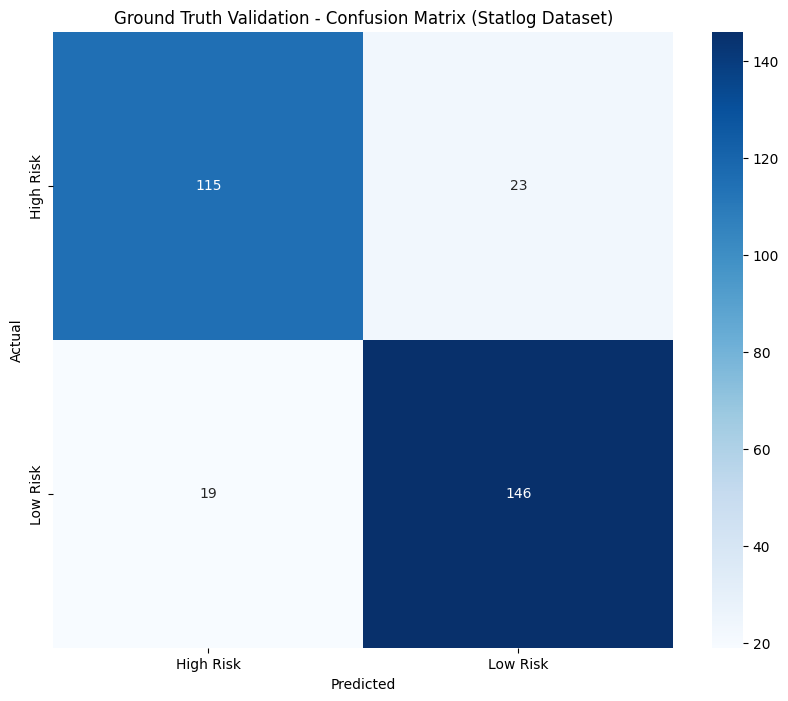


Performance Comparison:
--------------------------------------------------
Cleveland Current Study Model Metrics:
G-Mean = 0.916
Accuracy = 0.918
F1 = 0.925
Product = 0.778

Ground Truth (Statlog) Metrics:
Accuracy: 86.14%
Sensitivity: 83.33%
Specificity: 88.48%
F1-Score: 0.861


In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_statlog, predictions),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['High Risk', 'Low Risk'],
            yticklabels=['High Risk', 'Low Risk'])
plt.title('Ground Truth Validation - Confusion Matrix (Statlog Dataset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

test_metrics = print_metrics(y_test, test_pred)

print("\nPerformance Comparison:")
print("-" * 50)
print("Cleveland Current Study Model Metrics:")
print(f"G-Mean = {test_metrics[0]:.3f}")
print(f"Accuracy = {test_metrics[1]:.3f}")
print(f"F1 = {test_metrics[2]:.3f}")
print(f"Product = {test_metrics[3]:.3f}")

print("\nGround Truth (Statlog) Metrics:")
metrics = classification_report(y_statlog, predictions, output_dict=True)
print(f"Accuracy: {accuracy_score(y_statlog, predictions):.2%}")
print(f"Sensitivity: {metrics['0']['recall']:.2%}")
print(f"Specificity: {metrics['1']['recall']:.2%}")
print(f"F1-Score: {metrics['weighted avg']['f1-score']:.3f}")